General EDA

EDA inspired by 
https://ncss-tech.github.io/stats_for_soil_survey/book/eda.html 

In [1]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)


In [2]:
# === EXPLORATORY DATA ANALYSIS FOR SOIL DATA ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("=== SOIL DATA EXPLORATORY ANALYSIS ===")
print(f"Analysis run on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}") #why do we do this?
print("="*60)

# Store all tables in a dictionary for easy iteration
tables = {
    'analyses': analyses,
    'morpho': morpho, 
    'site_info': site_info,
    'soil_type': soil_type
}

def comprehensive_eda(df, table_name):
    """
    Perform comprehensive EDA on a dataframe
    """
    print(f"\n{'='*20} {table_name.upper()} TABLE ANALYSIS {'='*20}")
    
    # === 1. BASIC INFORMATION ===
    print(f"\n📊 BASIC INFORMATION:")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # === 2. DATA TYPES ===
    print(f"\n📋 DATA TYPES:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # === 3. MISSING DATA ANALYSIS ===
    print(f"\n❌ MISSING DATA:")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    
    if missing_data.sum() == 0:
        print("   ✅ No missing values found!")
    else:
        missing_summary = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_pct
        }).sort_values('Missing_Count', ascending=False)
        
        missing_cols = missing_summary[missing_summary['Missing_Count'] > 0]
        if len(missing_cols) > 0:
            print(f"   Total missing values: {missing_data.sum():,}")
            print(f"   Columns with missing data: {len(missing_cols)}")
            print("\n   Top columns with missing data:")
            for idx, (col, row) in enumerate(missing_cols.head(10).iterrows()):
                print(f"      {col}: {row['Missing_Count']:,} ({row['Missing_Percentage']:.1f}%)")
    
    # === 4. COLUMN INFORMATION ===
    print(f"\n📝 COLUMN DETAILS:")
    print("   Column Name (Type) | Unique Values | Sample Values")
    print("   " + "-"*65)
    
    for col in df.columns:
        col_type = str(df[col].dtype)
        unique_count = df[col].nunique()
        
        # Get sample non-null values
        non_null_vals = df[col].dropna()
        if len(non_null_vals) > 0:
            if col_type in ['object', 'string']:
                sample_vals = non_null_vals.head(3).tolist()
                sample_str = ", ".join([str(v)[:20] for v in sample_vals])
            else:
                sample_vals = non_null_vals.head(3).tolist()
                sample_str = ", ".join([str(v) for v in sample_vals])
        else:
            sample_str = "All null"
            
        print(f"   {col[:25]:25} ({col_type[:8]:8}) | {unique_count:11,} | {sample_str[:25]}")
    
    # === 5. NUMERIC COLUMNS ANALYSIS ===
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n📈 NUMERIC SUMMARY ({len(numeric_cols)} columns):")
        print(df[numeric_cols].describe().round(3))
        
        # Check for potential outliers using IQR method
        print(f"\n🎯 OUTLIER DETECTION (IQR method):")
        outlier_summary = []
        for col in numeric_cols:
            if df[col].notna().sum() > 0:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
                outlier_summary.append({
                    'Column': col,
                    'Outliers': len(outliers),
                    'Percentage': (len(outliers) / len(df)) * 100
                })
        
        outlier_df = pd.DataFrame(outlier_summary)
        if len(outlier_df) > 0:
            outlier_df = outlier_df.sort_values('Outliers', ascending=False)
            for _, row in outlier_df.head(10).iterrows():
                if row['Outliers'] > 0:
                    print(f"   {row['Column'][:30]:30}: {row['Outliers']:4d} ({row['Percentage']:.1f}%)")
    
    # === 6. CATEGORICAL COLUMNS ANALYSIS ===
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns
    if len(categorical_cols) > 0:
        print(f"\n📊 CATEGORICAL SUMMARY ({len(categorical_cols)} columns):")
        for col in categorical_cols:
            unique_count = df[col].nunique()
            most_common = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else "N/A"
            most_common_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            
            print(f"   {col[:35]:35}: {unique_count:4d} unique | Most common: '{str(most_common)[:20]}' ({most_common_count})")
            
            # Show top categories for columns with reasonable number of categories
            if 2 <= unique_count <= 20:
                top_cats = df[col].value_counts().head(5)
                print(f"      Top categories: {dict(top_cats)}")
    
    # === 7. DUPLICATE ANALYSIS ===
    print(f"\n🔄 DUPLICATE ANALYSIS:")
    duplicate_count = df.duplicated().sum()
    if duplicate_count > 0:
        print(f"   ⚠️  Found {duplicate_count:,} duplicate rows ({duplicate_count/len(df)*100:.1f}%)")
    else:
        print("   ✅ No duplicate rows found")
    
    # === 8. POTENTIAL ID COLUMNS ===
    print(f"\n🔑 POTENTIAL IDENTIFIER COLUMNS:")
    id_candidates = []
    for col in df.columns:
        unique_ratio = df[col].nunique() / len(df) if len(df) > 0 else 0
        if unique_ratio > 0.95:  # More than 95% unique values
            id_candidates.append((col, unique_ratio, df[col].nunique()))
    
    if id_candidates:
        print("   Columns with >95% unique values (potential IDs):")
        for col, ratio, unique_count in id_candidates:
            print(f"      {col}: {unique_count:,} unique ({ratio:.1%})")
    else:
        print("   No obvious identifier columns found")

# === RUN EDA FOR ALL TABLES ===
for table_name, df in tables.items():
    comprehensive_eda(df, table_name)

# === CROSS-TABLE ANALYSIS ===
print(f"\n{'='*25} CROSS-TABLE ANALYSIS {'='*25}")

print(f"\n🔗 TABLE RELATIONSHIPS & DATA INTEGRITY:")
print("   Based on your database schema, checking key relationships...")

# Check primary keys and foreign key relationships
print(f"\n🔑 PRIMARY KEY ANALYSIS:")
pk_info = {
    'site_info': 'site_info_id',
    'soil_type': 'soil_type_id', 
    'analyses': 'lab_sample_id',
    'morpho': 'morpho_id'
}

for table_name, pk_col in pk_info.items():
    if table_name in tables and pk_col in tables[table_name].columns:
        df = tables[table_name]
        total_rows = len(df)
        unique_pks = df[pk_col].nunique()
        null_pks = df[pk_col].isnull().sum()
        
        print(f"   {table_name:12} PK '{pk_col}': {unique_pks:,} unique, {null_pks} nulls")
        if unique_pks != total_rows - null_pks:
            print(f"      ⚠️  WARNING: PK not unique! {total_rows - null_pks - unique_pks} duplicates")

# Check foreign key relationships based on your schema
print(f"\n🔗 FOREIGN KEY RELATIONSHIP ANALYSIS:")

# 1. Check profile linkages (morpho and analyses should link to site_info via profile)
if all(t in tables for t in ['site_info', 'morpho', 'analyses']):
    site_profiles = set(tables['site_info']['profile'].dropna())
    
    print(f"   site_info profiles: {len(site_profiles):,} unique")
    
    # Check morpho -> site_info via profile
    if 'profile' in tables['morpho'].columns:
        morpho_profiles = set(tables['morpho']['profile'].dropna())
        morpho_orphans = morpho_profiles - site_profiles
        morpho_coverage = len(morpho_profiles - morpho_orphans) / len(morpho_profiles) * 100 if morpho_profiles else 0
        
        print(f"   morpho -> site_info: {len(morpho_orphans)} orphan profiles ({100-morpho_coverage:.1f}% orphaned)")
        if morpho_orphans:
            print(f"      Orphan profiles in morpho: {sorted(list(morpho_orphans))[:10]}...")
    
    # Check analyses -> site_info via profile  
    if 'profile' in tables['analyses'].columns:
        analyses_profiles = set(tables['analyses']['profile'].dropna())
        analyses_orphans = analyses_profiles - site_profiles
        analyses_coverage = len(analyses_profiles - analyses_orphans) / len(analyses_profiles) * 100 if analyses_profiles else 0
        
        print(f"   analyses -> site_info: {len(analyses_orphans)} orphan profiles ({100-analyses_coverage:.1f}% orphaned)")
        if analyses_orphans:
            print(f"      Orphan profiles in analyses: {sorted(list(analyses_orphans))[:10]}...")

# 2. Check soil_type relationship
if all(t in tables for t in ['site_info', 'soil_type']):
    if 'soil_type_id' in tables['site_info'].columns:
        site_soil_types = set(tables['site_info']['soil_type_id'].dropna())
        available_soil_types = set(tables['soil_type']['soil_type_id'].dropna())
        missing_soil_types = site_soil_types - available_soil_types
        
        print(f"   site_info -> soil_type: {len(missing_soil_types)} missing soil_type_ids")
        if missing_soil_types:
            print(f"      Missing soil_type_ids: {sorted(list(missing_soil_types))[:10]}...")

# 3. Check sample_id relationships (mentioned in your notes about missing sample_ids)
sample_id_tables = ['morpho', 'analyses']
if any('sample_id' in tables.get(t, {}).columns for t in sample_id_tables):
    print(f"\n📋 SAMPLE_ID ANALYSIS (noted as problematic in your schema):")
    for table_name in sample_id_tables:
        if table_name in tables and 'sample_id' in tables[table_name].columns:
            sample_ids = tables[table_name]['sample_id']
            null_count = sample_ids.isnull().sum()
            empty_count = (sample_ids == '').sum() if sample_ids.dtype == 'object' else 0
            total_missing = null_count + empty_count
            
            print(f"   {table_name:12}: {total_missing:,} missing sample_ids ({total_missing/len(sample_ids)*100:.1f}%)")

print(f"\n📊 DATA COMPLETENESS MATRIX:")
print("   Table relationships and data availability:")

# Create a completeness matrix for key linking columns
key_columns = {
    'site_info': ['site_info_id', 'profile', 'soil_type_id'],
    'morpho': ['morpho_id', 'profile', 'sample_id'], 
    'analyses': ['lab_sample_id', 'profile', 'sample_id'],
    'soil_type': ['soil_type_id']
}

for table_name, cols in key_columns.items():
    if table_name in tables:
        df = tables[table_name]
        print(f"   {table_name:12}:", end="")
        for col in cols:
            if col in df.columns:
                completeness = (1 - df[col].isnull().sum() / len(df)) * 100
                print(f" {col}({completeness:.0f}%)", end="")
        print()

# Look for common column names across tables
all_columns = {}
for table_name, df in tables.items():
    all_columns[table_name] = set(df.columns)

print(f"\n📋 COMMON COLUMN NAMES (potential relationships):")
for i, (table1, cols1) in enumerate(all_columns.items()):
    for j, (table2, cols2) in enumerate(all_columns.items()):
        if i < j:  # Avoid duplicate comparisons
            common_cols = cols1.intersection(cols2)
            if common_cols:
                print(f"   {table1} ↔ {table2}: {sorted(list(common_cols))}")

# === SUMMARY ===
print(f"\n{'='*30} SUMMARY {'='*30}")
total_rows = sum(df.shape[0] for df in tables.values())
total_cols = sum(df.shape[1] for df in tables.values())

print(f"📊 DATASET OVERVIEW:")
print(f"   Total records across all tables: {total_rows:,}")
print(f"   Total columns across all tables: {total_cols}")
print(f"   Number of tables: {len(tables)}")

for table_name, df in tables.items():
    print(f"   {table_name:12}: {df.shape[0]:6,} rows × {df.shape[1]:2d} cols")

print(f"\n🚨 KEY DATA QUALITY ISSUES IDENTIFIED:")
print("   Based on your schema and the analysis:")
print("   1. 4,270 sample records have no site_info linkage")
print("   2. Some missing sample_ids in morpho and analyses tables") 
print("   3. 8 profiles in analyses were not in site_info (you deleted these)")
print("   4. Check for any remaining orphan records in foreign key relationships")

print(f"\n🎯 RECOMMENDED NEXT STEPS:")
print("   1. Investigate the 4,270 orphaned samples - can they be linked to site_info?")
print("   2. Examine missing sample_id patterns - are they random or systematic?")
print("   3. Validate profile linkages between morpho/analyses and site_info")
print("   4. Consider data imputation strategies for critical missing values")
print("   5. Document data lineage for the missing relationships")

print(f"\n✅ EDA Complete! Review the analysis above to understand your soil data structure.")
print("   Focus on the data integrity issues before proceeding with analysis.")

=== SOIL DATA EXPLORATORY ANALYSIS ===
Analysis run on: 2025-08-25 17:55:13

==================== ANALYSES TABLE ANALYSIS ====================

📊 BASIC INFORMATION:
   Shape: 7,763 rows × 75 columns
   Memory usage: 15.57 MB

📋 DATA TYPES:
   float64: 43 columns
   object: 30 columns
   int64: 2 columns

❌ MISSING DATA:
   Total missing values: 226,635
   Columns with missing data: 40

   Top columns with missing data:
      u: 7,757.0 (99.9%)
      bi: 7,755.0 (99.9%)
      ni: 7,751.0 (99.8%)
      mo: 7,751.0 (99.8%)
      zn: 7,746.0 (99.8%)
      nb: 7,742.0 (99.7%)
      cd: 7,742.0 (99.7%)
      th: 7,737.0 (99.7%)
      ba: 7,736.0 (99.7%)
      ta: 7,734.0 (99.6%)

📝 COLUMN DETAILS:
   Column Name (Type) | Unique Values | Sample Values
   -----------------------------------------------------------------
   lab_sample_id             (int64   ) |       7,763 | 458, 894, 7
   analysis_id               (object  ) |       7,763 | Bg_113/57_4_1, Bg_253/57_
   morpho_id              

In [3]:
# review tables
tables = {
    "analyses": analyses,
    "morpho": morpho,
    "site_info": site_info,
    "samples": samples,
    "soil_type": soil_type,
    "usable_sites": usable_sites
}

for name, df in tables.items():
    print(f"\n=== {name} ===")
    df.info()



=== analyses ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7763 entries, 0 to 7762
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   lab_sample_id          7763 non-null   int64  
 1   analysis_id            7763 non-null   object 
 2   morpho_id              7763 non-null   object 
 3   sample_id              7763 non-null   int64  
 4   profile                7763 non-null   object 
 5   soil_biology_id        7763 non-null   object 
 6   eg                     2915 non-null   float64
 7   thick_sand             7327 non-null   float64
 8   fine_sand              7383 non-null   float64
 9   silt                   7343 non-null   float64
 10  clay                   7353 non-null   float64
 11  eq_hum                 5519 non-null   float64
 12  atm_1/3                7763 non-null   object 
 13  atm_15                 2155 non-null   float64
 14  caco3                  7763 non-null  

In [4]:
climate_feat.head()

,climate_id,mean_annual_temp,mean_annual_precip,koppen_climate,thornthwaite_climate,hydric_regime,thermal_regime
0,1,NaN,NaN,,Arido,,
1,2,NaN,NaN,,Humido,,
2,3,NaN,NaN,,,,
3,4,21.5,1500.0,"Tropical chuvoso com estacao seca no Inverno, ...",Humido,Tropustico udico,Iso-Hipertermico
4,5,NaN,NaN,,,,


In [5]:
samples.head()

,sample_id,profile,year,shelf,room,site_info_id
0,4692,P8_V S1,NaN,64,22,None
1,4693,P8_V S1,NaN,65,22,None
2,4694,P8_V S1,NaN,65,22,None
3,4697,P11_IV S3,NaN,65,22,None
4,4698,P11_IV S3,NaN,65,22,None


In [6]:
# Summary of counts per year (ignoring NULLs)
year_counts = (
    samples.dropna(subset=["year"])
            .groupby("year")
            .size()
            .reset_index(name="count")
            .sort_values("year")
)

print(year_counts)

# Also see min/max year for quick range
print("Year range:", samples["year"].min(), "-", samples["year"].max())

      year  count
0   1946.0     17
1   1951.0     28
2   1952.0    167
3   1953.0      9
4   1955.0    965
5   1956.0    966
6   1957.0   1113
7   1958.0    399
8   1959.0   1117
9   1960.0   2029
10  1961.0    553
11  1962.0   1554
12  1963.0   1947
13  1964.0    757
14  1965.0   1067
15  1966.0    974
16  1967.0   1020
Year range: 1946.0 - 1967.0


In [7]:
# Merge on 'profile'
sampNsite = pd.merge(samples, usable_sites, on="profile", how="inner")

# Group by district and year to see counts
district_year_counts = (
    sampNsite.dropna(subset=["year", "district"])
              .groupby(["district", "year"])
              .size()
              .reset_index(name="count")
              .sort_values(["district", "year"])
)

print(district_year_counts)

# Optional: just get the unique district/year combinations
unique_district_years = (
    sampNsite.dropna(subset=["year", "district"])
              [["district", "year"]]
              .drop_duplicates()
              .sort_values(["district", "year"])
)

print(unique_district_years)

           district    year  count
0             Bengo  1967.0     16
1          Benguela  1957.0    352
2          Benguela  1958.0    329
3          Benguela  1967.0      5
4               Bie  1961.0    114
5               Bie  1962.0    255
6    CUANDO-CUBANGO  1967.0      6
7           Cabinda  1959.0    539
8    Cuando-Cubango  1962.0     12
9    Cuando-Cubango  1966.0    203
10   Cuando-Cubango  1967.0     84
11       Cuanza Sul  1958.0     25
12       Cuanza Sul  1960.0     94
13       Cuanza Sul  1961.0    174
14       Cuanza Sul  1962.0    432
15            Huila  1967.0     12
16           Luanda  1961.0     10
17      Lunda Norte  1962.0      4
18      Lunda Norte  1965.0      5
19  Lundas e Moxico  1963.0     17
20  Lundas e Moxico  1964.0    184
21  Lundas e Moxico  1965.0    308
22          Malanje  1962.0      9
23          Malanje  1963.0   1404
24          Malanje  1965.0     13
25           Moxico  1963.0      3
26           Moxico  1964.0      8
27           Namibe 

## Looking at the Geographic Data we have to work with

ConnectionError: HTTPSConnectionPool(host='cartodb-basemaps-a.global.ssl.fastly.net', port=443): Max retries exceeded with url: /light_all/5/15/14.png (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x17e948390>: Failed to resolve 'cartodb-basemaps-a.global.ssl.fastly.net' ([Errno 8] nodename nor servname provided, or not known)"))

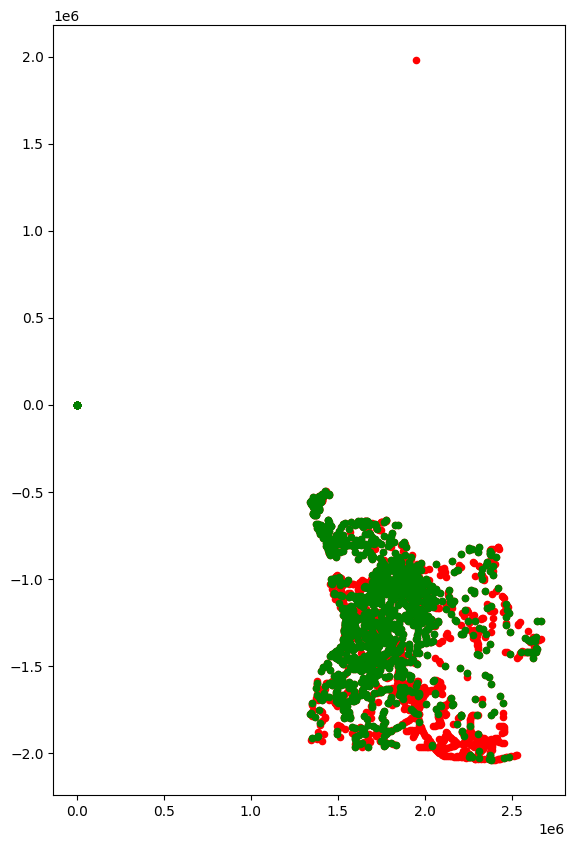

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Ensure CRS is correct (replace EPSG if needed)
gdf_all = gpd.GeoDataFrame(
    site_info,
    geometry=gpd.points_from_xy(site_info.X_coord, site_info.Y_coord),
    crs="EPSG:4326"
)

gdf_usable = gpd.GeoDataFrame(
    usable_sites,
    geometry=gpd.points_from_xy(usable_sites.X_coord, usable_sites.Y_coord),
    crs="EPSG:4326"
)

# Identify unusable sites
gdf_unusable = gdf_all[~gdf_all.index.isin(gdf_usable.index)]

# Reproject to Web Mercator for basemap
gdf_all = gdf_all.to_crs(epsg=3857)
gdf_usable = gdf_usable.to_crs(epsg=3857)
gdf_unusable = gdf_unusable.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot unusable sites in red
gdf_unusable.plot(ax=ax, color='red', markersize=20, label="Unusable Sites")
# Plot usable sites in green
gdf_usable.plot(ax=ax, color='green', markersize=20, label="Usable Sites")

# Add basemap directly via URL
ctx.add_basemap(
    ax,
    source="https://cartodb-basemaps-a.global.ssl.fastly.net/light_all/{z}/{x}/{y}.png"
)

# Legend & labels
plt.title("Usable vs Unusable Sites", fontsize=16)
plt.legend(markerscale=1.5, fontsize=12)
plt.axis("off")

plt.show()



🌍 GEOGRAPHIC DISTRIBUTION
------------------------------

🏘️ Sites per District:
Total districts: 18
district
Malanje            313
Cuanza Sul         181
Huila              165
Uige e Zaire       160
Benguela           149
Lundas e Moxico     95
Cabinda             94
Huambo              88
Bie                 81
Cuando-Cubango      65
Name: count, dtype: int64


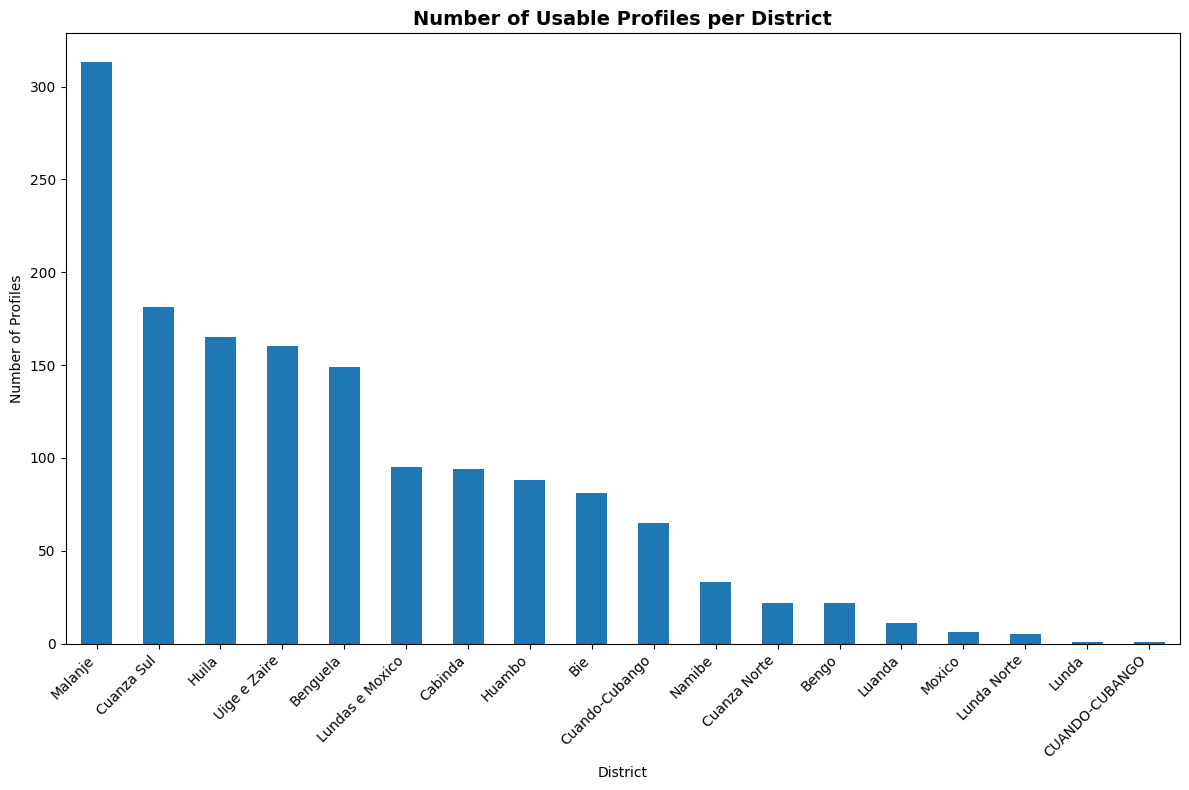

In [11]:
# === 2. GEOGRAPHIC DISTRIBUTION ANALYSIS ===
print(f"\n🌍 GEOGRAPHIC DISTRIBUTION")
print("-" * 30)
#print total usable sites 

# Sites per district/region
region_cols = ['district']  # Check which column exists
region_col = None
for col in region_cols:
    if col in usable_sites.columns:
        region_col = col
        break

if region_col:
    print(f"\n🏘️ Sites per {region_col.title()}:")
    region_counts = usable_sites[region_col].value_counts()
    print(f"Total {region_col}s: {len(region_counts)}")
    print(region_counts.head(10))
    
    # Plot top regions
    plt.figure(figsize=(12, 8))
    top_regions = region_counts.head(21)
    top_regions.plot(kind='bar')
    plt.title(f'Number of Usable Profiles per {region_col.title()}', fontsize=14, fontweight='bold')
    plt.xlabel(region_col.title())
    plt.ylabel('Number of Profiles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [12]:
# Count null values in each coordinate column
null_counts = usable_sites[["X_coord", "Y_coord"]].isnull().sum()

print("Missing coordinate counts in usable_sites:")
print(null_counts)


Missing coordinate counts in usable_sites:
X_coord    0
Y_coord    0
dtype: int64


In [7]:
# === 3. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth', 
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)



🧪 WORKING SAMPLES ANALYSIS
------------------------------
Working samples per district:
Total regions with samples: 16
Total working samples: 6,667

Top 10 regions by sample count:
district
Malanje            1421
Uige e Zaire        870
Cuanza Sul          723
Huila               699
Benguela            631
Lundas e Moxico     523
Cabinda             468
Huambo              450
Bie                 365
Cuando-Cubango      319
Name: count, dtype: int64


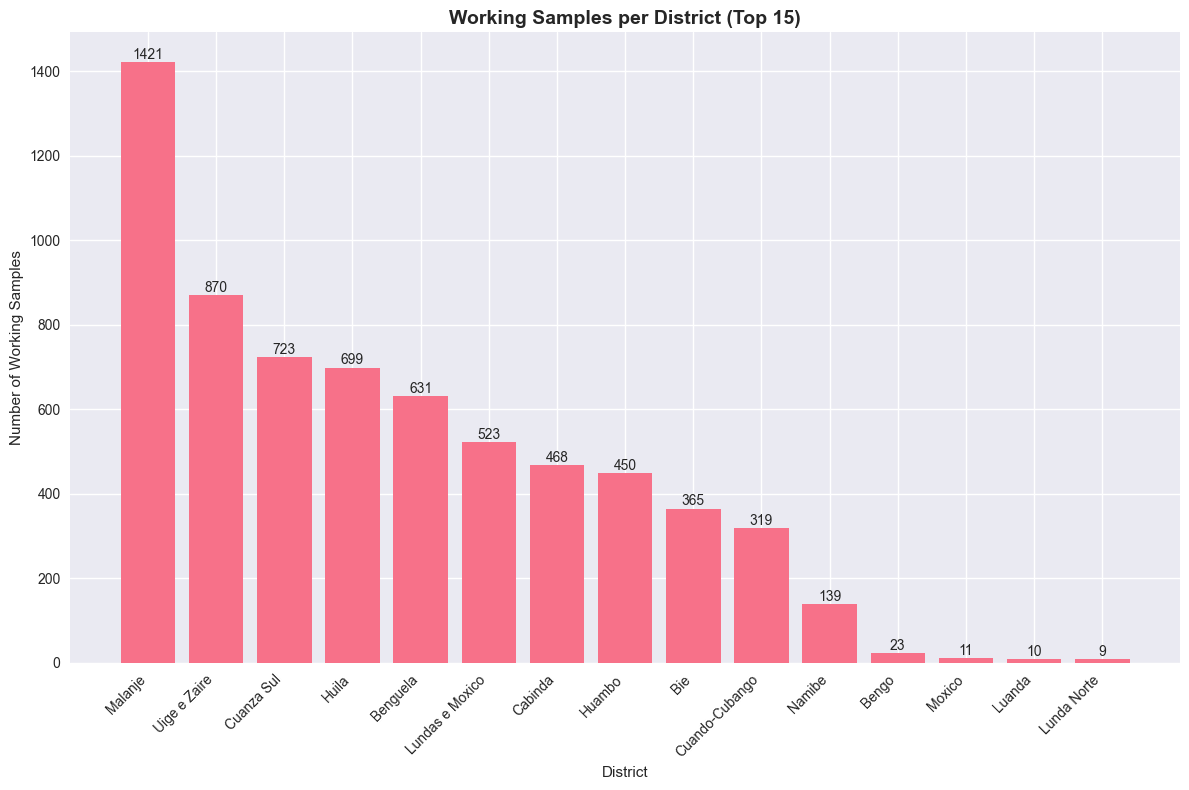

In [8]:
# === 4. WORKING SAMPLES ANALYSIS ===
print(f"\n🧪 WORKING SAMPLES ANALYSIS")
print("-" * 30)

# Samples with analysis data per region
if region_col and region_col in merged_final.columns:
    working_samples = merged_final[merged_final['analysis_id'].notna()]
    
    if len(working_samples) > 0:
        samples_per_region = working_samples[region_col].value_counts()
        
        print(f"Working samples per {region_col}:")
        print(f"Total regions with samples: {len(samples_per_region)}")
        print(f"Total working samples: {len(working_samples):,}")
        print("\nTop 10 regions by sample count:")
        print(samples_per_region.head(10))
        
        # Plot working samples per region
        plt.figure(figsize=(12, 8))
        top_sample_regions = samples_per_region.head(15)
        bars = plt.bar(range(len(top_sample_regions)), top_sample_regions.values)
        plt.title(f'Working Samples per {region_col.title()} (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel(region_col.title())
        plt.ylabel('Number of Working Samples')
        plt.xticks(range(len(top_sample_regions)), top_sample_regions.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(top_sample_regions.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [9]:
merged_final.columns

Index(['analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth',
       'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron',
       'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl',
       'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density',
       'porosity', 'morpho_id_morpho', 'horizon_layer', 'upper_depth',
       'lower_depth', 'moisture_degree', 'root_quantity', 'root_diameter',
       'texture', 'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom', 'year'],
      dtype='object')

In [10]:
## carbon stock calculation test
# Ensure no missing values in required columns for calculation
cols_needed = ['organic_carbon', 'bulk_density', 'sample_depth']
df_soc = merged_final.dropna(subset=cols_needed).copy()

# Calculate SOC stock (mg C/cm²)
df_soc['SOC_stock_mg_per_cm2'] = (
    df_soc['bulk_density'] *
    df_soc['organic_carbon'] *
    df_soc['sample_depth']
)

# Optional: display summary statistics
print(df_soc['SOC_stock_mg_per_cm2'].describe())

# If you want to add this back to your main dataframe (aligned by index)
merged_final = merged_final.merge(
    df_soc[['SOC_stock_mg_per_cm2']],
    left_index=True,
    right_index=True,
    how='left'
)


count    4510.000000
mean       17.100433
std        16.884321
min       -28.421250
25%         7.821887
50%        13.209234
75%        21.249074
max       352.531441
Name: SOC_stock_mg_per_cm2, dtype: float64


In [11]:
import pandas as pd
from scipy import stats  # for mode calculation

# Make sure 'SOC_stock_mg_per_cm2' exists and drop NA to avoid errors
df = merged_final.dropna(subset=['SOC_stock_mg_per_cm2'])

# Helper function to calculate mode, returns first mode or NaN if no mode found
def calc_mode(series):
    modes = stats.mode(series, nan_policy='omit')
    if modes.count[0] > 0:
        return modes.mode[0]
    else:
        return pd.NA

# 1. Aggregate by profile
profile_stats = df.groupby('profile')['SOC_stock_mg_per_cm2'].agg(
    average='mean',
    median='median',
    sum='sum',
).reset_index()

# Calculate mode separately because pandas doesn't support mode in agg well
profile_modes = df.groupby('profile')['SOC_stock_mg_per_cm2'].apply(calc_mode).reset_index(name='mode')

# Merge mode into profile_stats
profile_stats = profile_stats.merge(profile_modes, on='profile')

# 2. Aggregate by district (replace 'district' with actual column name)
district_stats = df.groupby('district')['SOC_stock_mg_per_cm2'].agg(
    average='mean',
    median='median',
    sum='sum',
).reset_index()

district_modes = df.groupby('district')['SOC_stock_mg_per_cm2'].apply(calc_mode).reset_index(name='mode')

district_stats = district_stats.merge(district_modes, on='district')

# 3. Total SOC stock for Angola (sum over all)
total_soc_stock = df['SOC_stock_mg_per_cm2'].sum()

print("SOC Stock Summary by Profile:")
print(profile_stats.head())

print("\nSOC Stock Summary by District:")
print(district_stats.head())

print(f"\nTotal SOC Stock for Angola (mg C/cm²): {total_soc_stock:,.2f}")


SOC Stock Summary by Profile:
  profile    average     median         sum       mode
0  100_56  13.161807  14.110696   65.809035   5.011545
1  100_58  22.098545  22.648197   66.295634  19.096803
2  100_59  22.342839  23.770139   67.028517  18.161480
3  100_61  27.623042  26.612822  110.492169  17.749443
4  100_63   6.764940   7.024606   33.824698   3.598951

SOC Stock Summary by District:
         district    average     median          sum       mode
0           Bengo  11.550878   6.616137   265.670190   1.883289
1        Benguela  17.319886  12.939734  7811.268727  10.919386
2             Bie  13.310534  10.135932  3607.154612   1.494137
3  CUANDO-CUBANGO   3.752881   2.835345    18.764406   1.925097
4         Cabinda  20.020194  17.424739  4724.765812   4.982655

Total SOC Stock for Angola (mg C/cm²): 77,122.95


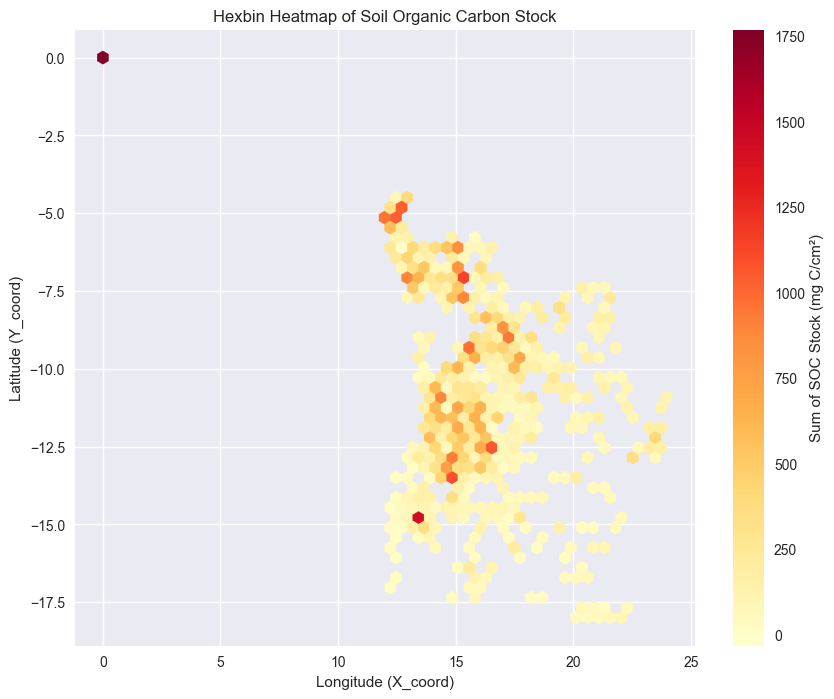

In [12]:
import numpy as np
import matplotlib.pyplot as plt

df_plot = merged_final.dropna(subset=['X_coord', 'Y_coord', 'SOC_stock_mg_per_cm2'])

plt.figure(figsize=(10, 8))

hb = plt.hexbin(
    df_plot['X_coord'], 
    df_plot['Y_coord'], 
    C=df_plot['SOC_stock_mg_per_cm2'], 
    gridsize=50, 
    cmap='YlOrRd', 
    reduce_C_function=np.sum
)

plt.colorbar(hb, label='Sum of SOC Stock (mg C/cm²)')
plt.title("Hexbin Heatmap of Soil Organic Carbon Stock")
plt.xlabel("Longitude (X_coord)")
plt.ylabel("Latitude (Y_coord)")
plt.show()


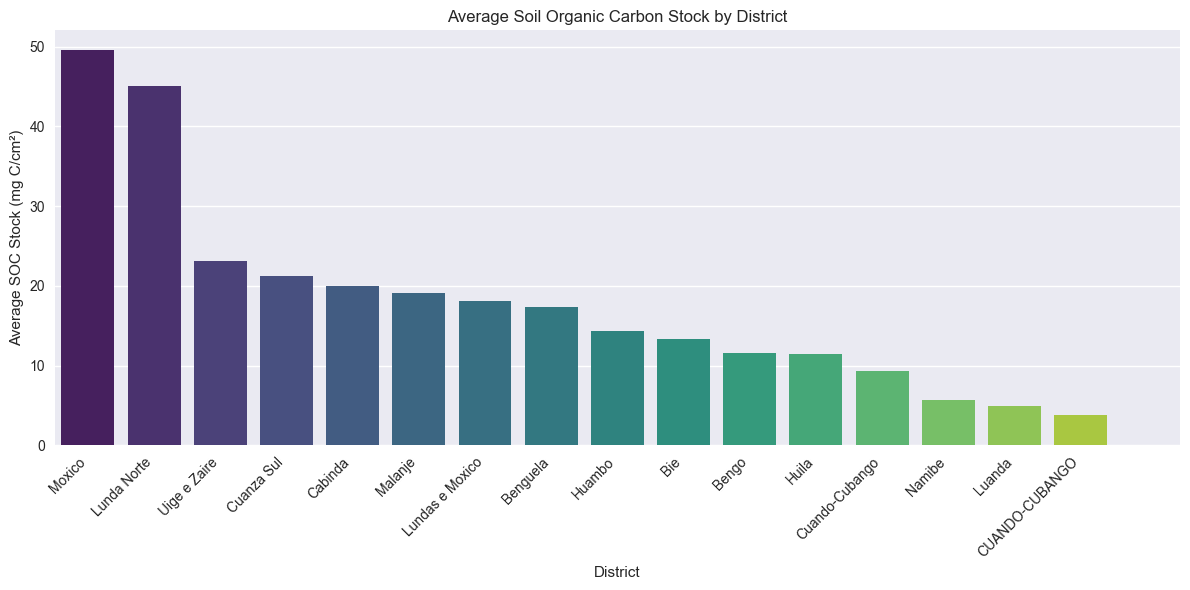

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate average SOC stock per district
district_summary = merged_final.groupby('district')['SOC_stock_mg_per_cm2'].mean().reset_index()

# Sort districts by average SOC for nicer plotting
district_summary = district_summary.sort_values(by='SOC_stock_mg_per_cm2', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=district_summary, x='district', y='SOC_stock_mg_per_cm2', palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.title('Average Soil Organic Carbon Stock by District')
plt.ylabel('Average SOC Stock (mg C/cm²)')
plt.xlabel('District')
plt.tight_layout()
plt.show()


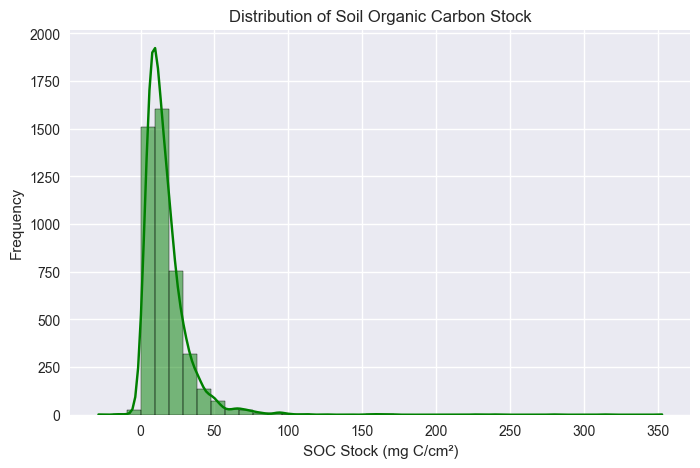

In [14]:
plt.figure(figsize=(8, 5))

sns.histplot(merged_final['SOC_stock_mg_per_cm2'].dropna(), bins=40, kde=True, color='green')

plt.title('Distribution of Soil Organic Carbon Stock')
plt.xlabel('SOC Stock (mg C/cm²)')
plt.ylabel('Frequency')
plt.show()


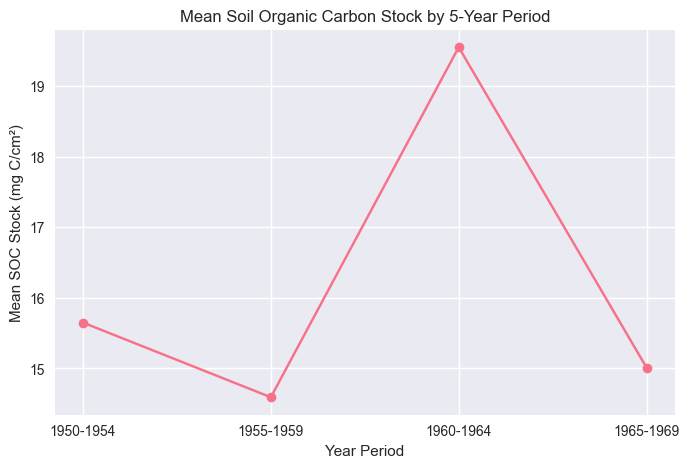

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create 5-year bins
bins = list(range(1950, 1975, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]
merged_final['year_bin'] = pd.cut(merged_final['year'], bins=bins, labels=labels, right=False)

# Aggregate mean SOC stock per bin
soc_by_bin = merged_final.groupby('year_bin')['SOC_stock_mg_per_cm2'].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(soc_by_bin['year_bin'], soc_by_bin['SOC_stock_mg_per_cm2'], marker='o')
plt.title('Mean Soil Organic Carbon Stock by 5-Year Period')
plt.xlabel('Year Period')
plt.ylabel('Mean SOC Stock (mg C/cm²)')
plt.grid(True)
plt.show()


                             OLS Regression Results                             
Dep. Variable:     SOC_stock_mg_per_cm2   R-squared:                       0.065
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     1.046
Date:                  Tue, 12 Aug 2025   Prob (F-statistic):              0.323
Time:                          15:34:23   Log-Likelihood:                -58.789
No. Observations:                    17   AIC:                             121.6
Df Residuals:                        15   BIC:                             123.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        700.5630    684.321

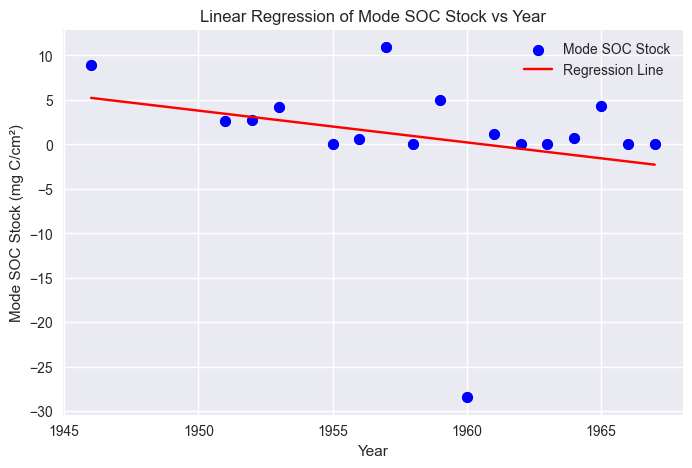

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import statsmodels.api as sm

# Compute mode SOC stock per year
# Since mode returns an array and count, we get the first mode value for each year
def get_mode(series):
    m = mode(series, nan_policy='omit')
    if len(m.mode) > 0:
        return m.mode[0]
    else:
        return np.nan

mode_per_year = merged_final.groupby('year')['SOC_stock_mg_per_cm2'].apply(get_mode).reset_index()

# Drop years with NaN mode
mode_per_year = mode_per_year.dropna()

# Prepare data for regression
X = mode_per_year['year']
y = mode_per_year['SOC_stock_mg_per_cm2']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

print(model.summary())

# Plot the data and regression line
plt.figure(figsize=(8,5))
sns.scatterplot(x='year', y='SOC_stock_mg_per_cm2', data=mode_per_year, s=80, color='blue', label='Mode SOC Stock')
plt.plot(X, model.predict(X_const), color='red', label='Regression Line')
plt.title('Linear Regression of Mode SOC Stock vs Year')
plt.xlabel('Year')
plt.ylabel('Mode SOC Stock (mg C/cm²)')
plt.legend()
plt.grid(True)
plt.show()


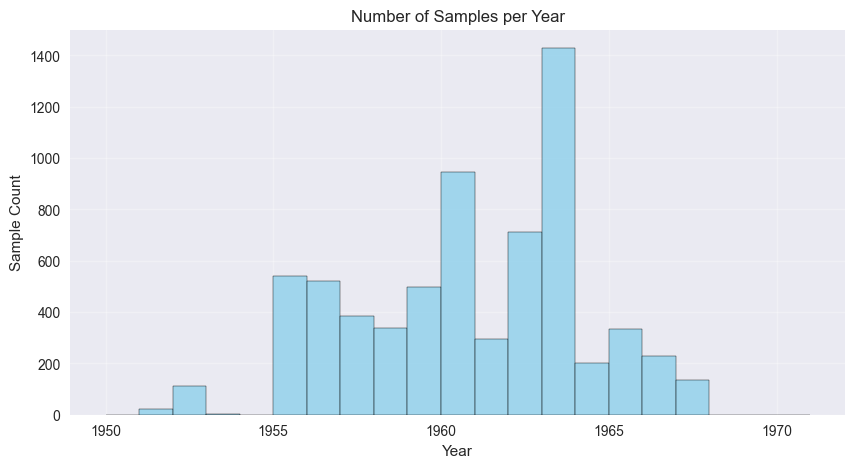

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(merged_final['year'], bins=range(1950, 1972), kde=False, color='skyblue')

plt.title('Number of Samples per Year')
plt.xlabel('Year')
plt.ylabel('Sample Count')
plt.grid(True, alpha=0.3)
plt.show()


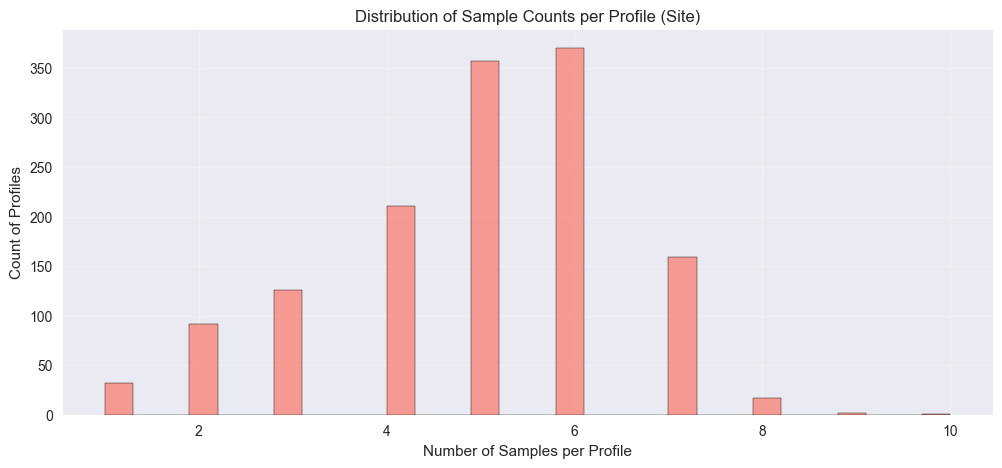

In [19]:
plt.figure(figsize=(12, 5))

# Count samples per profile
profile_counts = merged_final['profile'].value_counts()

sns.histplot(profile_counts, bins=30, color='salmon')

plt.title('Distribution of Sample Counts per Profile (Site)')
plt.xlabel('Number of Samples per Profile')
plt.ylabel('Count of Profiles')
plt.grid(True, alpha=0.3)
plt.show()


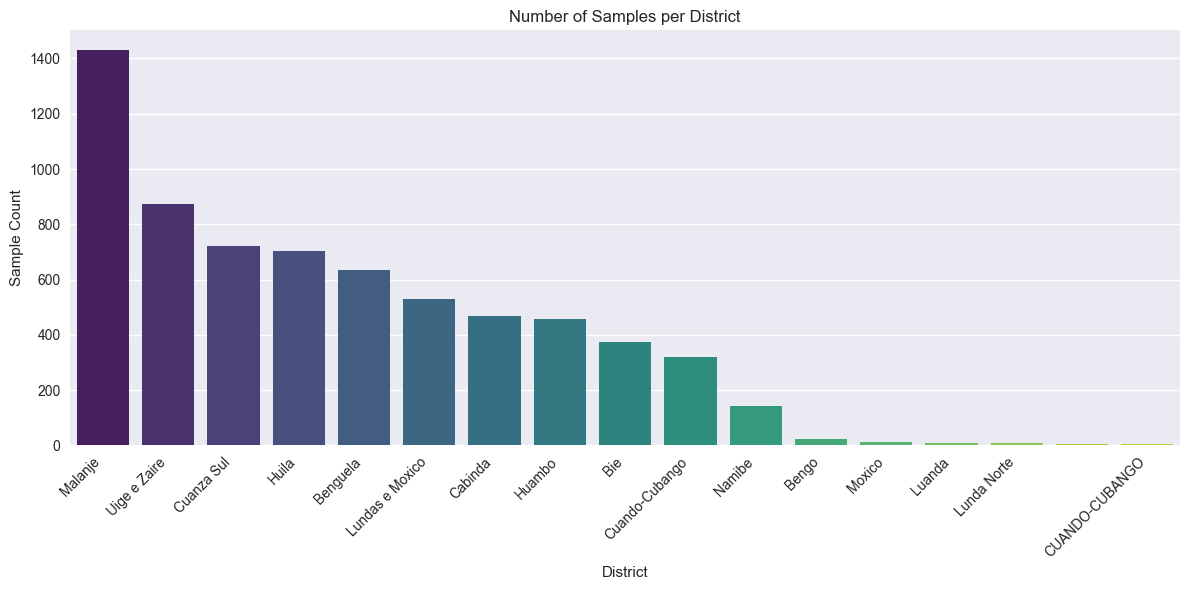

In [20]:
plt.figure(figsize=(12, 6))

district_counts = merged_final['district'].value_counts().reset_index()
district_counts.columns = ['district', 'sample_count']

sns.barplot(data=district_counts, x='district', y='sample_count', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Samples per District')
plt.xlabel('District')
plt.ylabel('Sample Count')
plt.tight_layout()
plt.show()


In [21]:
merged_final.columns

Index(['analysis_id', 'morpho_id', 'sample_id', 'profile', 'depth',
       'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron',
       'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl',
       'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density',
       'porosity', 'morpho_id_morpho', 'horizon_layer', 'upper_depth',
       'lower_depth', 'moisture_degree', 'root_quantity', 'root_diameter',
       'texture', 'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom', 'year', 'SOC_stock_mg_per_cm2',
       'year_bin'],
      dtype='object')


🧪 WORKING SAMPLES ANALYSIS
------------------------------
Working samples per district:
Total districts with samples: 18
Total working samples: 36,162

Top 10 districts by sample count:
district
Malanje            7532
Uige e Zaire       4999
Cuanza Sul         3825
Huila              3710
Benguela           2966
Lundas e Moxico    2789
Cabinda            2631
Huambo             2091
Bie                2042
Cuando-Cubango     1620
Name: count, dtype: int64


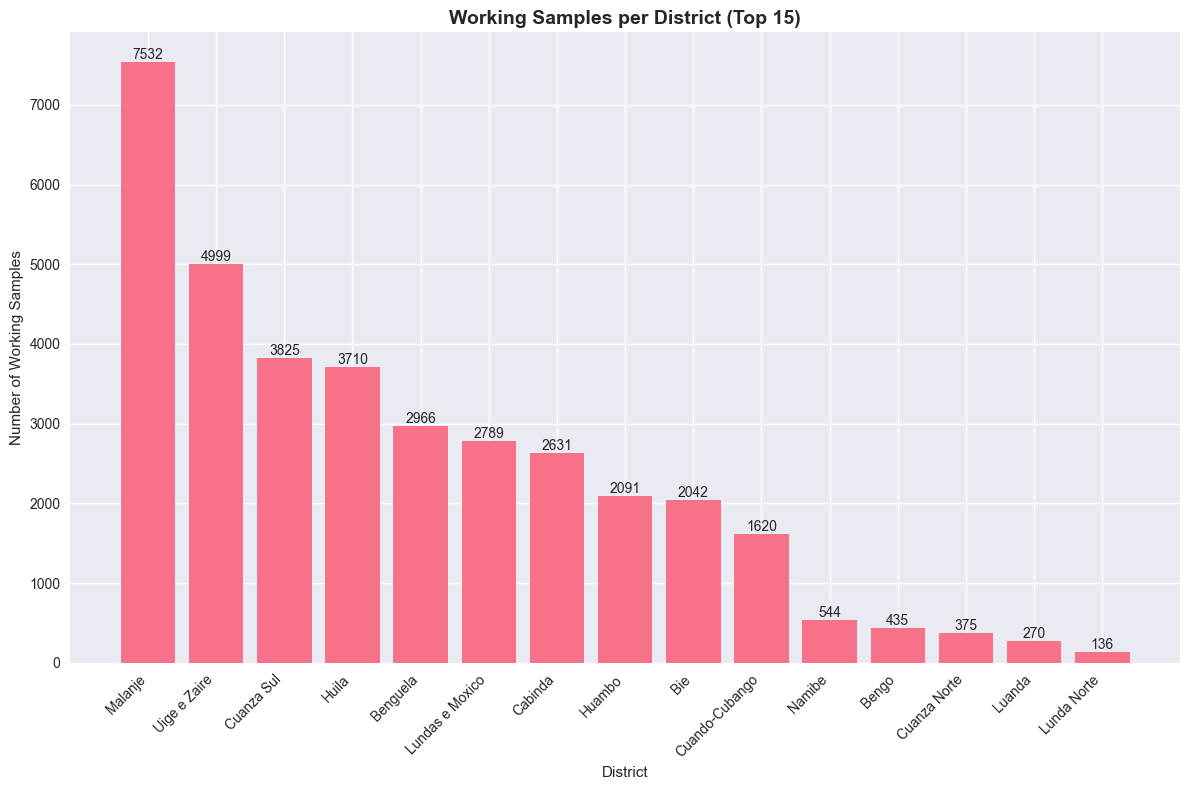

In [20]:
# === 4. WORKING SAMPLES ANALYSIS ===
print(f"\n🧪 WORKING SAMPLES ANALYSIS")
print("-" * 30)

# Samples with analysis data per district
if 'district' in merged_final.columns:
    working_samples = merged_final[merged_final['analysis_id'].notna()]
    
    if len(working_samples) > 0:
        samples_per_district = working_samples['district'].value_counts()
        
        print(f"Working samples per district:")
        print(f"Total districts with samples: {len(samples_per_district)}")
        print(f"Total working samples: {len(working_samples):,}")
        print("\nTop 10 districts by sample count:")
        print(samples_per_district.head(10))
        
        # Plot working samples per district
        plt.figure(figsize=(12, 8))
        top_sample_districts = samples_per_district.head(15)
        bars = plt.bar(range(len(top_sample_districts)), top_sample_districts.values)
        plt.title('Working Samples per District (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel('District')
        plt.ylabel('Number of Working Samples')
        plt.xticks(range(len(top_sample_districts)), top_sample_districts.index, rotation=45, ha='right')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(top_sample_districts.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


🏔️ SOIL HORIZON ANALYSIS
------------------------------
Horizon layers analysis:
  Total profiles: 2,302
  Average horizons per site: 17.23
  Median horizons per site: 15
  Min horizons: 1
  Max horizons: 72

Distribution of horizons per site:
1       8
2      47
3     105
4     152
5     278
6     214
7      52
8      50
9      96
10     36
Name: count, dtype: int64


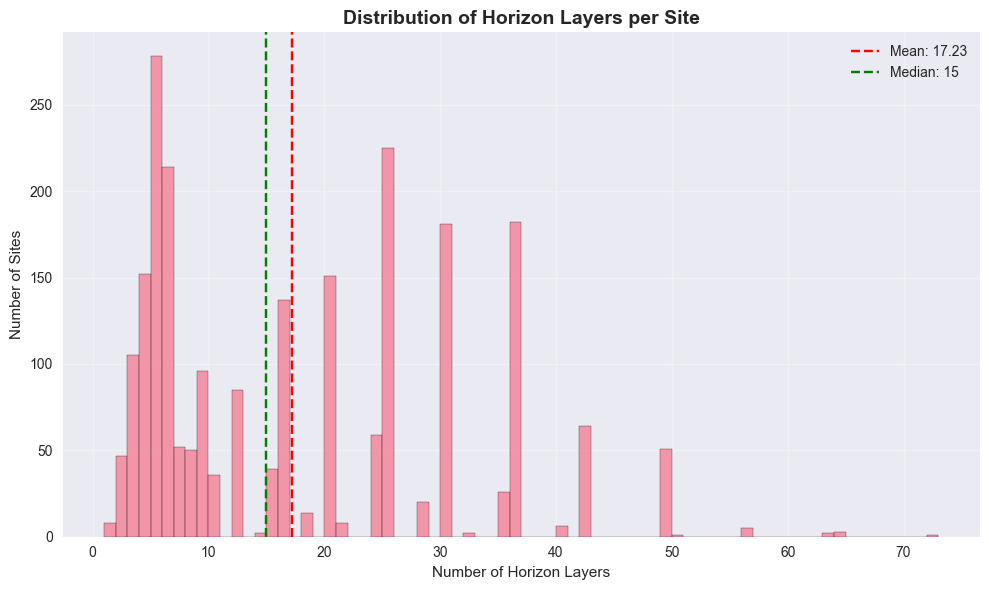

In [21]:
# === 5. HORIZON ANALYSIS ===
print(f"\n🏔️ SOIL HORIZON ANALYSIS")
print("-" * 30)

# Group by profile to analyze horizons per site
profile_col = 'profile'
if profile_col in merged_final.columns:
    # Count horizons per profile/site
    horizons_per_site = merged_final.groupby(profile_col).size()
    
    print(f"Horizon layers analysis:")
    print(f"  Total profiles: {len(horizons_per_site):,}")
    print(f"  Average horizons per site: {horizons_per_site.mean():.2f}")
    print(f"  Median horizons per site: {horizons_per_site.median():.0f}")
    print(f"  Min horizons: {horizons_per_site.min()}")
    print(f"  Max horizons: {horizons_per_site.max()}")
    
    print(f"\nDistribution of horizons per site:")
    horizon_distribution = horizons_per_site.value_counts().sort_index()
    print(horizon_distribution.head(10))
    
    # Plot histogram of horizons per site
    plt.figure(figsize=(10, 6))
    plt.hist(horizons_per_site, bins=range(1, horizons_per_site.max() + 2), 
             edgecolor='black', alpha=0.7)
    plt.title('Distribution of Horizon Layers per Site', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Horizon Layers')
    plt.ylabel('Number of Sites')
    plt.grid(True, alpha=0.3)
    
    # Add statistics text
    plt.axvline(horizons_per_site.mean(), color='red', linestyle='--', 
                label=f'Mean: {horizons_per_site.mean():.2f}')
    plt.axvline(horizons_per_site.median(), color='green', linestyle='--', 
                label=f'Median: {horizons_per_site.median():.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
merged_final.columns

Index(['analysis_id', 'morpho_id_analyses', 'sample_id_analyses', 'profile',
       'depth', 'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15',
       'free_iron', 'organic_carbon', 'p205', 'organic_material', 'ph_h2o',
       'ph_kcl', 'exchangable_bases_sum', 'cec', 'morpho_id_morpho',
       'sample_id_morpho', 'horizon_layer', 'upper_depth', 'lower_depth',
       'moisture_degree', 'root_quantity', 'root_diameter', 'texture',
       'structure_type', 'structure_class', 'structure_degree',
       'pore_diameter', 'pore_quantity', 'pore_shape', 'dry_color_name',
       'dry_hue', 'dry_value', 'dry_chroma', 'moist_color_name', 'moist_hue',
       'moist_value', 'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature', 'site_info_id',
       'X_coord', 'Y_coord', 'district', 'geo_features_id', 'climate_id',
       'topo_id', 'soil_type_id', 'geom'],
      dtype='object')


📏 DEPTH ANALYSIS
------------------------------
Depth analysis (using 'sample_depth'):
  Total depth measurements: 36,162
  Depth range: -70.0 to 131.0
  Mean depth: 25.6
  Median depth: 26.0


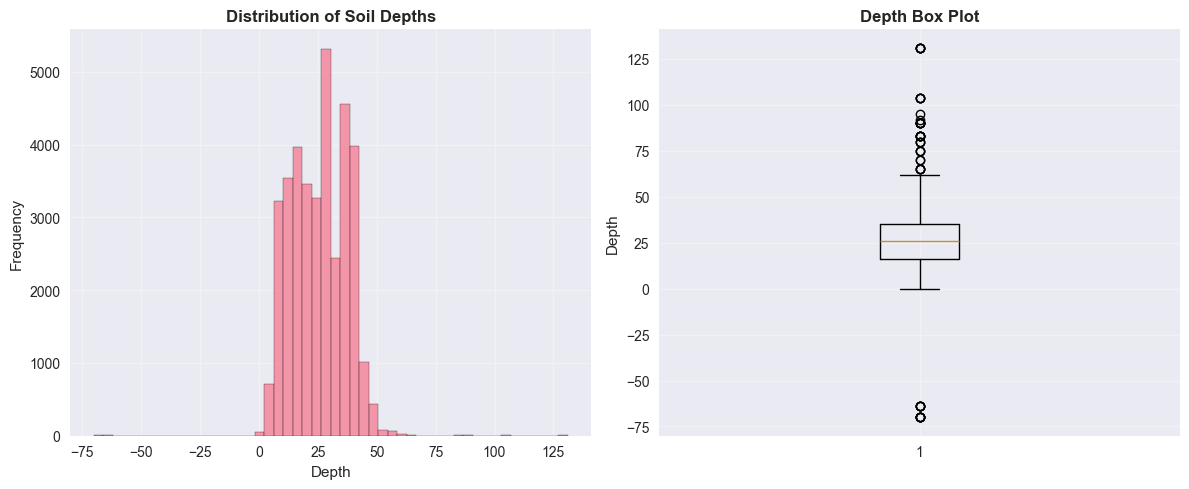

In [27]:
# === 6. DEPTH ANALYSIS ===
print(f"\n📏 DEPTH ANALYSIS")
print("-" * 30)

# Define the depth column you want to use
depth_col = 'sample_depth'

if depth_col in merged_final.columns:
    depths = merged_final[depth_col].dropna()

    if len(depths) > 0:
        print(f"Depth analysis (using '{depth_col}'):")
        print(f"  Total depth measurements: {len(depths):,}")
        print(f"  Depth range: {depths.min():.1f} to {depths.max():.1f}")
        print(f"  Mean depth: {depths.mean():.1f}")
        print(f"  Median depth: {depths.median():.1f}")
        
        # Plot depth distribution
        plt.figure(figsize=(12, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        plt.hist(depths, bins=50, edgecolor='black', alpha=0.7)
        plt.title('Distribution of Soil Depths', fontsize=12, fontweight='bold')
        plt.xlabel('Depth')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        # Boxplot
        plt.subplot(1, 2, 2)
        plt.boxplot(depths)
        plt.title('Depth Box Plot', fontsize=12, fontweight='bold')
        plt.ylabel('Depth')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid values found in '{depth_col}'.")
else:
    print(f"Column '{depth_col}' not found in DataFrame.")


In [ ]:
## find out where thata -75 depth is and take it out

In [23]:
# === 7. HORIZON DESIGNATION ANALYSIS ===
print(f"\n🔤 HORIZON DESIGNATION ANALYSIS")
print("-" * 30)

horizon_cols = ['horizon', 'horizon_designation', 'layer', 'layer_designation']
available_horizon_cols = [col for col in horizon_cols if col in merged_final.columns]

if available_horizon_cols:
    horizon_col = available_horizon_cols[0]
    horizons = merged_final[horizon_col].dropna()
    
    if len(horizons) > 0:
        horizon_counts = horizons.value_counts()
        print(f"Horizon designation analysis (using {horizon_col}):")
        print(f"  Total horizon designations: {len(horizons):,}")
        print(f"  Unique designations: {len(horizon_counts)}")
        print(f"\nTop 15 horizon designations:")
        print(horizon_counts.head(15))
        
        # Plot horizon designations
        plt.figure(figsize=(14, 8))
        top_horizons = horizon_counts.head(20)
        bars = plt.bar(range(len(top_horizons)), top_horizons.values)
        plt.title('Most Common Horizon Designations', fontsize=14, fontweight='bold')
        plt.xlabel('Horizon Designation')
        plt.ylabel('Count')
        plt.xticks(range(len(top_horizons)), top_horizons.index, rotation=45, ha='right')
        
        # Add value labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    str(top_horizons.values[i]), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Classify depth by horizon designation
        if depth_col in merged_final.columns:
            horizon_depth = merged_final.groupby(horizon_col)[depth_col].agg(['mean', 'median', 'std', 'count']).round(2)
            horizon_depth = horizon_depth.sort_values('mean')
            
            print(f"\nDepth statistics by horizon designation (top 15):")
            print(horizon_depth.head(15))


🔤 HORIZON DESIGNATION ANALYSIS
------------------------------


In [28]:

# === 7. HORIZON DESIGNATION ANALYSIS ===
# Check columns exist
required_cols = ['profile', 'horizon_layer', 'sample_depth', 'upper_depth', 'lower_depth']
missing_cols = [col for col in required_cols if col not in merged_final.columns]

if missing_cols:
    print(f"Missing columns: {missing_cols}")
else:
    # Drop rows with missing depth info to avoid errors
    df = merged_final.dropna(subset=['profile', 'horizon_layer', 'upper_depth', 'lower_depth'])

    # Group by profile
    horizon_summary = df.groupby('profile').agg(
        num_horizons = ('horizon_layer', 'nunique'),             # count unique horizons
        min_depth = ('upper_depth', 'min'),                      # shallowest start
        max_depth = ('lower_depth', 'max'),                      # deepest end
        total_thickness = ('sample_depth', 'sum')                # sum thickness of horizons
    ).reset_index()

    print(horizon_summary)

    # Optional: Show profiles with their number of horizons and depth range nicely
    for _, row in horizon_summary.iterrows():
        print(f"Profile {row['profile']}: {row['num_horizons']} horizons, depth range {row['min_depth']} - {row['max_depth']} cm, total thickness {row['total_thickness']:.1f} cm")


      profile  num_horizons  min_depth  max_depth  total_thickness
0     100C_62             6        0.0      180.0              0.0
1     100C_63             5        0.0      165.0              0.0
2      100_56             4        0.0      190.0            500.0
3      100_58             4        0.0      110.0            468.0
4      100_59             3        0.0       67.0            201.0
...       ...           ...        ...        ...              ...
2213    9C_60             6        0.0      170.0            888.0
2214    9C_63             5        0.0      170.0            625.0
2215     9_59             4        0.0      100.0              0.0
2216     9_62             5        0.0      175.0            625.0
2217     9_63             5        0.0       90.0            450.0

[2218 rows x 5 columns]
Profile 100C_62: 6 horizons, depth range 0.0 - 180.0 cm, total thickness 0.0 cm
Profile 100C_63: 5 horizons, depth range 0.0 - 165.0 cm, total thickness 0.0 cm
Profile 100


Summary Statistics:
       num_horizons    min_depth    max_depth  total_thickness
count   2218.000000  2218.000000  2218.000000      2218.000000
mean       4.698377     0.120153   145.093327       413.403517
std        1.283674     2.966375    43.466149       378.331108
min        1.000000     0.000000     8.000000         0.000000
25%        4.000000     0.000000   115.000000         0.000000
50%        5.000000     0.000000   165.000000       368.000000
75%        6.000000     0.000000   175.000000       715.000000
max        9.000000   116.000000   280.000000      1722.000000


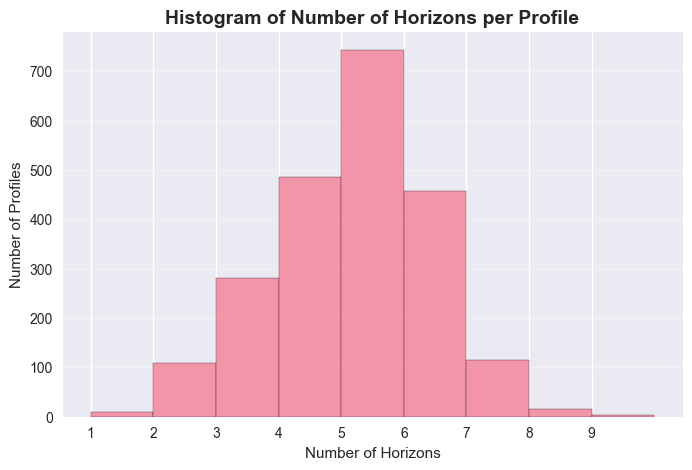

In [29]:
import matplotlib.pyplot as plt

# Assuming `horizon_summary` is the DataFrame from before

# Summary statistics for numeric columns
summary_stats = horizon_summary.describe()
print("\nSummary Statistics:")
print(summary_stats[['num_horizons', 'min_depth', 'max_depth', 'total_thickness']])

# Histogram for number of horizons per profile
plt.figure(figsize=(8,5))
plt.hist(horizon_summary['num_horizons'], bins=range(1, horizon_summary['num_horizons'].max() + 2), 
         edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Horizons per Profile', fontsize=14, fontweight='bold')
plt.xlabel('Number of Horizons')
plt.ylabel('Number of Profiles')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(1, horizon_summary['num_horizons'].max() + 1))
plt.show()

In [ ]:
#General EDA questions
# what is it? graphical output and descriptive statistics for our data

#ABOUT THE DATA
# How many sites per country
# how many sites per district
# do I need to break into even more specific site groupings

# histogram of sites per region
# histogram of working samples per region

# How many horizon layers per site
# depth range of horizon layers
# classify depth by its soil horizon designation

# generalize horizon labels --find out if any python package/function can set horizon label basd

#crosstabulate
## soil designation (taxonomic group and particle size)

#Pattern matching
## variation of particle size classes are within a specific subgroup (like a specific soil horizon)
## pattern match on taxonomic group, geomorphology or parent material

# filtering

# common landforms in area, commanalities in climate, 
    ## parent material, taxonomic history, geomorphic data, ecological site history (?) useful



In [ ]:
## Descriptive statistics
# mean, medium, and mode clay, sand, silt content
# number of observations for each horizon, for each site